In [89]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import chardet
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import heapq
import re
import plotnine
import copy
import pydot
import graphviz
from graphviz import Source
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from IPython.display import display
from pprint import pprint

In [2]:
# Importing processed data into notebook

sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm'
datapath = os.path.join(sourcepath, 'data','processed','IBM_HR_Data_Cleaned.csv')

IBMData = pd.read_csv(datapath)

In [3]:
# Dropping irrelevant variables

IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)

In [4]:
# Changing the types of some variables 

numvars = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 
          'PercentSalaryHike','PerformanceRating','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
          'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
newnumvars = ['Education','EnvironmentSatisfaction','JobInvolvement','JobLevel','JobSatisfaction','PerformanceRating',
              'RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']
catvars = [item for item in IBMData.columns.to_list() if item not in numvars and item not in newnumvars and item != 'Attrition']

In [5]:
IBMData[numvars] = IBMData[numvars].apply(pd.to_numeric, axis = 1, downcast = 'float')
IBMData[newnumvars] = IBMData[newnumvars].apply(pd.to_numeric, axis = 1, downcast = 'float')
IBMData[catvars] = IBMData[catvars].astype('category')

In [6]:
# Now rename some of the categorical variable levels

IBMData['BusinessTravel'].cat.rename_categories(
        {'Travel_Rarely':'Rare','Travel_Frequently':'Freq','Non-Travel':'No'}, inplace = True)
IBMData['Department'].cat.rename_categories(
    {'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
IBMData['EducationField'].cat.rename_categories(
    {'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'EducHR'}, inplace = True)
IBMData['JobRole'].cat.rename_categories(
    {'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'ManufDir','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'ResDir','Human Resources':'RoleHR'}, inplace = True)

In [7]:
# Now re-categorize the Attrition (outcome) variable from object to int

exit_status_map = {'Yes':1, 'No':0}
IBMData['Attrition'] = IBMData['Attrition'].map(exit_status_map)

In [8]:
# Now check the data types of the columns

IBMData.dtypes

Age                          float32
Attrition                      int64
BusinessTravel              category
DailyRate                    float32
Department                  category
DistanceFromHome             float32
Education                    float32
EducationField              category
EnvironmentSatisfaction      float32
Gender                      category
HourlyRate                   float32
JobInvolvement               float32
JobLevel                     float32
JobRole                     category
JobSatisfaction              float32
MaritalStatus               category
MonthlyIncome                float32
MonthlyRate                  float32
NumCompaniesWorked           float32
OverTime                    category
PercentSalaryHike            float32
PerformanceRating            float32
RelationshipSatisfaction     float32
StockOptionLevel             float32
TotalWorkingYears            float32
TrainingTimesLastYear        float32
WorkLifeBalance              float32
Y

In [9]:
# Now generate a new dataframe and then separate the predictors from outcome, and encode the dummies

IBMDataNew = IBMData.copy(deep = True)
IBMDataNewLabel = IBMDataNew['Attrition'].copy(deep = True)
IBMDataNew.drop(['Attrition'], axis = 1, inplace = True)
IBMDataNew = pd.get_dummies(IBMDataNew)

In [11]:
# Now check some of the characteristics of the datasets created and the initial dataset

print('Size of the initial data frame: {}'.format(IBMData.shape))
print('Size of the new data frame with predictors: {}'.format(IBMDataNew.shape))
print('Size of the new data frame with labels: {}'.format(len(IBMDataNewLabel)))
print('\nVariable Names in initial data frame: ', IBMData.columns.to_list())
print('\nVariance Names in new data frame with predictors: ', IBMDataNew.columns.to_list())

Size of the initial data frame: (1470, 31)
Size of the new data frame with predictors: (1470, 51)
Size of the new data frame with labels: 1470

Variable Names in initial data frame:  ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Variance Names in new data frame with predictors:  ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSa

In [62]:
# Now we split the data into training and test sets

seed = 50
Xtrain, Xtest, Ytrain, Ytest = train_test_split(IBMDataNew, IBMDataNewLabel, test_size = 0.25, random_state = seed)

# Now show some of the characteristics of the test and train sets
print('Shapes of train and test predictors sets respectively are: ', Xtrain.shape, Xtest.shape)
print('Size of train and test labels respectively are: ', len(Ytrain), len(Ytest))
print('\nProportion of exits in train and test sets respectively: ', round(sum(Ytrain)/len(Ytrain),3), round(sum(Ytest)/len(Ytest),3))

# Now split the main data as well by using the index of the train and test sets
IBMData_train = IBMData.loc[Xtrain.index,:].copy(deep = True)
IBMData_test = IBMData.loc[Xtest.index,:].copy(deep = True)

Shapes of train and test predictors sets respectively are:  (1102, 51) (368, 51)
Size of train and test labels respectively are:  1102 368

Proportion of exits in train and test sets respectively:  0.161 0.163


### Implementing a Simple Logistic Regression

In [79]:
## Defining the forumula to be used for the simple logistic regression
# Iterate through the feature list in the main data
# If the feature is int/float, then include that with a '+' sign in the formula string
# If the feature is a category then include the correct base level in the category name

catbasedict = {'BusinessTravel':'No', 'Department':'HR', 'EducationField':'EducHR','Gender':'Female',
               'JobRole':'RoleHR', 'MaritalStatus':'Single','OverTime':'No'}
counter = 0
formula = 'Attrition ~ '
for item in IBMData.columns.to_list():
    if(item is not 'Attrition' and IBMData[item].dtype.name == 'float32'):
        if(counter == 0):
            formula = formula + item
        else:
            formula = formula + ' + ' + item
        counter = counter + 1    
    elif(item is not 'Attrition' and IBMData[item].dtype.name == 'category'):
        if(counter == 0):
            formula = formula + 'C(' + item + ', Treatment(reference = "' + catbasedict[item] + '"))'
        else:
            formula = formula + ' + ' + 'C(' + item + ', Treatment(reference = "' + catbasedict[item] + '"))'
        counter = counter + 1

counter = 0        
formula_simple = 'Attrition ~ '
for item in IBMData.columns.to_list():
    if(item is not 'Attrition' and IBMData[item].dtype.name == 'float32'):
        if(counter == 0):
            formula_simple = formula_simple + item
        else:
            formula_simple = formula_simple + ' + ' + item
        counter = counter + 1    
    elif(item is not 'Attrition' and IBMData[item].dtype.name == 'category'):
        if(counter == 0):
            formula_simple = formula_simple + 'C(' + item + ')'
        else:
            formula_simple = formula_simple + ' + ' + 'C(' + item + ')'
        counter = counter + 1
        
counter = 0
formula_2verify = 'Attrition ~ '
for item in IBMData.columns.to_list():
    if(item is not 'Attrition' and counter == 0):
        formula_2verify = formula_2verify + item
    else:
        formula_2verify = formula_2verify + ' + ' + item
    counter = counter + 1    
        
print('Formula to be used for logistic regression:\n')
print(formula)
print()
print(formula_simple)
print()
print(formula_2verify)

Formula to be used for logistic regression:

Attrition ~ Age + C(BusinessTravel, Treatment(reference = "No")) + DailyRate + C(Department, Treatment(reference = "HR")) + DistanceFromHome + Education + C(EducationField, Treatment(reference = "EducHR")) + EnvironmentSatisfaction + C(Gender, Treatment(reference = "Female")) + HourlyRate + JobInvolvement + JobLevel + C(JobRole, Treatment(reference = "RoleHR")) + JobSatisfaction + C(MaritalStatus, Treatment(reference = "Single")) + MonthlyIncome + MonthlyRate + NumCompaniesWorked + C(OverTime, Treatment(reference = "No")) + PercentSalaryHike + PerformanceRating + RelationshipSatisfaction + StockOptionLevel + TotalWorkingYears + TrainingTimesLastYear + WorkLifeBalance + YearsAtCompany + YearsInCurrentRole + YearsSinceLastPromotion + YearsWithCurrManager

Attrition ~ Age + C(BusinessTravel) + DailyRate + C(Department) + DistanceFromHome + Education + C(EducationField) + EnvironmentSatisfaction + C(Gender) + HourlyRate + JobInvolvement + JobLev

In [81]:
# Now Implement the logistic regression model 

logit_model = smf.logit(formula_simple, IBMData_train).fit(max_iter = 5000)

         Current function value: 0.290094
         Iterations: 35


In [82]:
# Getting the marginal effects of the explanatory variables

print('Marginal Effects of the Explanatory Variables')
AME = logit_model.get_margeff(at = 'overall', method = 'dydx')
print(AME.summary())

Marginal Effects of the Explanatory Variables
        Logit Marginal Effects       
Dep. Variable:              Attrition
Method:                          dydx
At:                           overall
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
C(BusinessTravel)[T.Freq]          0.1768      0.044      4.028      0.000       0.091       0.263
C(BusinessTravel)[T.Rare]          0.1037      0.041      2.502      0.012       0.022       0.185
C(Department)[T.R&D]               1.5368    547.740      0.003      0.998   -1072.015    1075.088
C(Department)[T.Sales]             1.4777    547.740      0.003      0.998   -1072.074    1075.029
C(EducationField)[T.LifeSc]       -0.0907      0.079     -1.153      0.249      -0.245       0.063
C(EducationField)[T.Marketing]    -0.0674      0.084     -0.803      0.422      -0.232       0.097
C(Educatio

In [83]:
print('Baseline Estimates from Logit Model:\n')
logit_model.summary()

Baseline Estimates from Logit Model:



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1057
Method:                           MLE   Df Model:                           44
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                  0.3417
Time:                        14:25:18   Log-Likelihood:                -319.68
converged:                      False   LL-Null:                       -485.64
Covariance Type:            nonrobust   LLR p-value:                 7.850e-46
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -16.7927   6162.894     -0.003      0.998   -1.21e+04    1.21e+04
C(BusinessTravel)[T.Freq]          1.9898      0.504      3.950      0.000       1.002       2.977
C(BusinessTravel)[T.Rare]          1.1666      0.469      2.485      0.013       0.246       2.087
C(Department)[T.R&D]              17.2909   6162.894      0.003      0.998   -1.21e+04    1.21e+04
C(Department)[T.Sales]            16.6258   6162.894      0.003      0.998   -1.21e+04    1.21e+04
C(EducationField)[T.LifeSc]       -1.0206      0.888     -1.150      0.250      -2.760       0.719
C(EducationField)[T.Marketing]    -0.7587      0.946     -0.802      0.423      -2.613       1.095
C(EducationField)[T.Medical]      -1.1969      0.891     -1.343      0.179      -2.944       0.550
C(EducationField)[T.Other]        -1.1348      0.957     -1.185      0.236      -3.011       0.742
C(EducationField)[T.Technical]     0.0266      0.903      0.030      0.976      -1.742       1.796
C(Gender)[T.Male]                  0.4004      0.216      1.852      0.064      -0.023       0.824
C(JobRole)[T.RoleHR]              18.7100   6162.894      0.003      0.998   -1.21e+04    1.21e+04
C(JobRole)[T.LabTech]              1.6809      0.575      2.921      0.003       0.553       2.809
C(JobRole)[T.Manager]              0.3051      0.990      0.308      0.758      -1.634       2.245
C(JobRole)[T.ManufDir]             0.1889      0.626      0.302      0.763      -1.039       1.417
C(JobRole)[T.ResDir]              -1.0210      1.058     -0.965      0.334      -3.094       1.052
C(JobRole)[T.Scientist]            0.5797      0.591      0.980      0.327      -0.580       1.739
C(JobRole)[T.SalexExec]            1.6090      1.409      1.142      0.253      -1.153       4.371
C(JobRole)[T.SalesRep]             3.1301      1.455      2.152      0.031       0.279       5.981
C(MaritalStatus)[T.Married]        0.5370      0.315      1.705      0.088      -0.080       1.154
C(MaritalStatus)[T.Single]         1.4556      0.409      3.559      0.000       0.654       2.257
C(OverTime)[T.Yes]                 1.9128      0.225      8.512      0.000       1.472       2.353
Age                               -0.0185      0.016     -1.168      0.243      -0.049       0.013
DailyRate                         -0.0006      0.000     -2.282      0.023      -0.001   -8.49e-05
DistanceFromHome                   0.0548      0.012      4.443      0.000       0.031       0.079
Education                         -0.0681      0.100     -0.679      0.497      -0.265       0.128
EnvironmentSatisfaction           -0.4226      0.098     -4.297      0.000      -0.615      -0.230
HourlyRate                        -0.0002      0.005     -0.040      0.968      -0.010       0.010
JobInvolvement                    -0.5216      0.144     -3.626      0.000      -0.804      -0.240
JobLevel                          -0.2165      0.357     -0.606      0.54

The model implemented above clearly does not converge. This is possibly because of collinearity in the
features being used or the large number of categorical variables being used. To get around this problem 
we will use the Recursive Feature Elimination (possibly with Cross-Validation) method to select among the 
set of all features, and then run a logistic regression on the final list of features selected. 

In [147]:
# Use the following algorithm for RFE
# First one hot encode the categorical variables and then use logistic regression along with RFE to select features
# Then even if one of the levels of any categorical variable is included, then select all of the levels for that categorical variable
# In RFE we need to select the number of variables to keep, so iterate over the number of variables (including one hot encoded dummies)
# Then show the abs(log likelihood value)  

def RFE_Logit(Xtrain, Ytrain, include):
    
    models = []
    selected_features = []
    
    for i in np.arange(1, Xtrain.shape[1]+1):
        logreg = LogisticRegression()
        rfe = RFE(estimator = logreg, n_features_to_select = i)
        rfe = rfe.fit(Xtrain, Ytrain)
        cols2select = Xtrain.columns[rfe.support_].to_list()
    
        if include:
            print('Yay')
        
   
        logit_model = sm.Logit(Ytrain, Xtrain[cols2select]).fit(disp = 0)
    
        models.append(logit_model)
        selected_features.append(cols2select)
        
    return models, selected_features    

In [148]:
# Now training the model with no extra feature inclusion

models, selected_features = RFE_Logit(Xtrain, Ytrain, False)

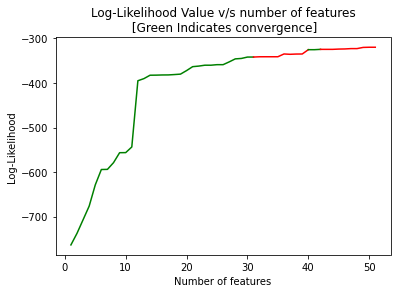

[50]
    num_features     loglike  convergence  color
0              1 -763.537292         True  green
1              2 -737.516212         True  green
2              3 -706.968933         True  green
3              4 -676.377775         True  green
4              5 -628.810109         True  green
5              6 -594.219818         True  green
6              7 -593.914109         True  green
7              8 -578.815639         True  green
8              9 -556.477892         True  green
9             10 -556.284431         True  green
10            11 -543.643753         True  green
11            12 -394.918748         True  green
12            13 -390.076716         True  green
13            14 -382.496640         True  green
14            15 -382.324818         True  green
15            16 -381.938986         True  green
16            17 -381.833126         True  green
17            18 -381.020018         True  green
18            19 -380.042093         True  green
19            2

In [234]:
# Now plot the log likelhood value against the number of features selected and then choose the one with the highest

num_features = np.arange(1, Xtrain.shape[1]+1)
loglike = [logitmodel.llf for logitmodel in models]
convergence = [logitmodel.mle_retvals['converged'] for logitmodel in models]
newframe = pd.DataFrame({'num_features':num_features, 'loglike':loglike, 'convergence':convergence})
label2color = {True:'green', False:'red'}
newframe['color'] = newframe['convergence'].apply(lambda convergence: label2color[convergence])

# Now iterate through the column 'convergence' and then select the breakpoints where convergence changes
breakpoints = []
start = 0
for i in np.arange(len(newframe)-1):
    if(newframe.iloc[i,2]!=newframe.iloc[i+1,2]):
        breakpoints.append((start, i, newframe.iloc[i,3]))
        start = i + 1
breakpoints.append((start, i+1, newframe.iloc[start,3]))

fig, ax = plt.subplots()
for (start, end, color) in breakpoints:
    if start > 0:
        start = start - 1
    ax.plot(newframe.num_features[start:end+1], newframe.loglike[start:end+1], color = color, label = '')
ax.set_title('Log-Likelihood Value v/s number of features\n [Green Indicates convergence]')
ax.set_xlabel('Number of features')
ax.set_ylabel('Log-Likelihood')
plt.show()        

# Now select the model with highest log-likelihood value along with convergence
optimalindex = heapq.nlargest(1, range(len(newframe)), key = lambda x: newframe.loglike[x])
print(optimalindex)

newframe = newframe.query('convergence == True')
print(newframe)

In [ ]:
# Issues to take care of: regularization in LogisticRegression, regularization in LogisticRegression, regularization parameter tuning, 
# Parameter selection whether to include all the remaining levels, other hyperparameter tuning, choosing the statistics to plot

# First do feature selection and show metrics
# Then with selected features do logistic regression with hyperparaneter tuning 
# Then do a combination of feature selection and hyperparamerer tuning 

